In [ ]:
pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=9bd74dcebf6afcfa6409dde95550773ba0996d64a7d481260c9c0385f170391a
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [ ]:
import torch
from torch.utils.data import DataLoader, Subset, Dataset, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import idx2numpy
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import os
import idx2numpy
RANDOM_SEED = 42
BATCH_SIZE = 64

In [ ]:
# File paths
TRAIN_IMAGES_PATH = "/train-images.idx3-ubyte"
TRAIN_LABELS_PATH = "/train-labels.idx1-ubyte"
TEST_IMAGES_PATH = "/t10k-images.idx3-ubyte"
TEST_LABELS_PATH = "/t10k-labels.idx1-ubyte"
# Load images and labels
train_labels = idx2numpy.convert_from_file(TRAIN_LABELS_PATH)
test_labels = idx2numpy.convert_from_file(TEST_LABELS_PATH)
test_images = idx2numpy.convert_from_file(TEST_IMAGES_PATH)
train_images = idx2numpy.convert_from_file(TRAIN_IMAGES_PATH)
# Normalize images to [0, 1] and convert to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Custom Dataset class
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None): # Changed _init_ to __init__
        self.images = images
        self.labels = labels
        self.transform = transform
    def __len__(self): # Changed _len_ to __len__
        return len(self.images)
    def __getitem__(self, idx): # Changed _getitem_ to __getitem__
        image = self.images[idx]
        label = self.labels[idx]
        # Convert to float and apply transformations
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize manually
        return image, label
# Create datasets
train_val_dataset = MNISTDataset(train_images, train_labels, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=transform)
# Stratified split for training and validation
# Stratify the split into training (50K) and validation (10K)
indices = np.arange(len(train_val_dataset))
train_indices, val_indices = train_test_split(indices, test_size=1/6, stratify=train_labels, random_state=RANDOM_SEED)
# Subset datasets
train_dataset = torch.utils.data.Subset(train_val_dataset, train_indices)
val_dataset = torch.utils.data.Subset(train_val_dataset, val_indices)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 50000
Validation dataset size: 10000
Test dataset size: 10000


In [ ]:
# Define the feedforward neural network
class FeedforwardNN(nn.Module):  #neural network defined
    def __init__(self, input_size=784, hidden_size1=128, hidden_size2=64, output_size=10):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) # make the y=w^T x + b
        self.relu1 = nn.ReLU()  # make activation function 1
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()  # make activation function 2
        self.fc3 = nn.Linear(hidden_size2, output_size)  # applying linearity for output
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input  make it 1-d
        x = self.fc1(x)  # Apply the first linear layer
        x = self.relu1(x)  # Apply the activation function
        x = self.fc2(x)  # Apply the second linear layer
        x = self.relu2(x)  # Apply the activation function
        x = self.fc3(x)  # Apply the output linear layer
        return x  # return the output
# Initialize the model, loss function, and optimizer
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Gradient Stochastic Descent

this is our neural network model which is by default composed of (28 x 28) = 784 input units and 2 hidden layers : layer 1 composed of 128 neuron and layer 2 composed of 64 neuron , and output of 10 classes which represents numbers from 0 -> 9  
our activation function for layer 1 is relu and for layer 2 is relu and for sure for the output linear


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    train_losses,val_losses,train_acc,val_acc = [], [],[],[]
    for epoch in range(epochs):  # loop for maximum 100 iterations
        model.train() # training the model
        train_loss = 0.0 #initialize loss for each epoch
        for images, labels in train_loader:  # loop on training data
            # Zero the gradients
            optimizer.zero_grad()  # start with zero gradient
            # Forward pass
            outputs = model(images)  # get the expected output of the images depending on model
            loss = criterion(outputs, labels)  # calculate the loss for the iteration
            # Backward pass
            loss.backward()  # calculate the gradient of the loss function
            optimizer.step() #make a stochastic gradient descent step
            train_loss += loss.item()
            train_loss /= len(train_loader) # Average training loss
        train_losses.append(train_loss)
        correct = 0
        total = 0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for images, labels in train_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                #predicted: stores the indices of the maximum values, corresponding to the predicted class labels.
                total += labels.size(0) #A counter that accumulates the number of samples processed so far during the loop.
                correct += (predicted == labels).sum().item()
        trainacc=correct/total
        train_acc.append(trainacc)
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad(): #statement in PyTorch is used to temporarily disable gradient computation
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_loss /= len(val_loader)
            # Average validation loss
        val_losses.append(val_loss)
        validacc=correct/total
        val_acc.append(validacc)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} , train acc :{trainacc:.4f} , validation acc : {validacc:.4f}")
        #early exit process happen
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # Reset patience counter
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Stopping early!")
            return train_losses, val_losses ,train_acc,val_acc
    return train_losses, val_losses ,train_acc,val_acc
train_losses, val_losses,train_accuracy,val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch [1/100], Train Loss: 0.0006, Val Loss: 0.0020 , train acc :0.8425 , validation acc : 0.8425
Epoch [2/100], Train Loss: 0.0007, Val Loss: 0.0007 , train acc :0.8948 , validation acc : 0.8946
Epoch [3/100], Train Loss: 0.0002, Val Loss: 0.0004 , train acc :0.9020 , validation acc : 0.9022
Epoch [4/100], Train Loss: 0.0007, Val Loss: 0.0005 , train acc :0.8975 , validation acc : 0.8966
Epoch [5/100], Train Loss: 0.0003, Val Loss: 0.0005 , train acc :0.9142 , validation acc : 0.9135
Epoch [6/100], Train Loss: 0.0003, Val Loss: 0.0003 , train acc :0.9255 , validation acc : 0.9249
Epoch [7/100], Train Loss: 0.0002, Val Loss: 0.0003 , train acc :0.9316 , validation acc : 0.9312
Epoch [8/100], Train Loss: 0.0000, Val Loss: 0.0002 , train acc :0.9366 , validation acc : 0.9358
Epoch [9/100], Train Loss: 0.0009, Val Loss: 0.0003 , train acc :0.9311 , validation acc : 0.9301
Epoch [10/100], Train Loss: 0.0007, Val Loss: 0.0003 , train acc :0.9324 , validation acc : 0.9309
Epoch [11/100], Tra

Applying training for the model and applying stopping early technique

0.9771


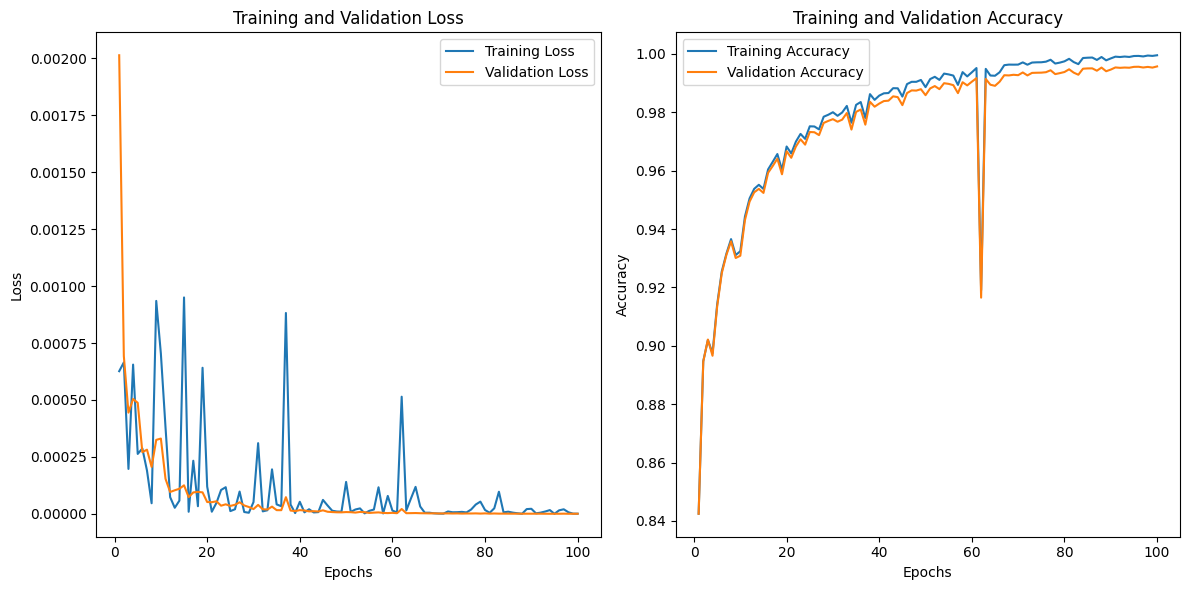

In [ ]:
def plot_fn():
  correct = 0
  total = 0
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      for images, labels in test_loader:
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)  # Get predicted class
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  besttest_accuracy=correct/total # till now this is the best test accuracy
  best_model=model
  print(besttest_accuracy)
  # Calculate accuracies
  # Plot training and validation loss
  epochs = range(1, len(train_losses) + 1)
  plt.figure(figsize=(12, 6))
  # Loss plot
  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="Training Loss")
  plt.plot(epochs, val_losses, label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training and Validation Loss")
  plt.legend()
  # Accuracy plot
  plt.subplot(1, 2, 2)
  #train_accuracies = [train_accuracy] * len(epochs)  # Placeholder for per-epoch accuracy
  #val_accuracies = [val_accuracy] * len(epochs)  # Placeholder for per-epoch accuracy
  plt.plot(epochs, train_accuracy, label="Training Accuracy")
  plt.plot(epochs, val_accuracy, label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Training and Validation Accuracy")
  plt.legend()
  plt.tight_layout()
  plt.show()
plot_fn()


plotting the output of the default neural netwoork and comparing the validation accuracy to the training accuracy and validation error to training error

default model is the one before now we start in analysis ...


Here we are trying 4 different learning rates and making a comparison between them and among them we will choose the best test accuracy which will considerate which model is the best:

In [ ]:
besttest_accuracy=0.9416
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer1 = optim.SGD(model.parameters(), lr=0.001)
train_loss1,val_loss1,train_acc1,val_acc1=train_model(model, train_loader, val_loader, criterion, optimizer1, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(f"training with learning rate = 0.001 gives accuracy= {test_accuracy:.4f}")
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy
#-------------------------------------------------------------------------------
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer2 = optim.SGD(model.parameters(), lr=0.0001)
train_loss2,val_loss2,train_acc2,val_acc2=train_model(model, train_loader, val_loader, criterion, optimizer2, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(f"training with learning rate = 0.0001 gives accuracy= {test_accuracy:.4f}")
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy
#-------------------------------------------------------------------------------
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer3 = optim.SGD(model.parameters(), lr=0.1)
train_loss3,val_loss3,train_acc3,val_acc3=train_model(model, train_loader, val_loader, criterion, optimizer3, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(f"training with learning rate = 0.1 gives accuracy= {test_accuracy:.4f}")
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy
#-------------------------------------------------------------------------------
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer4 = optim.SGD(model.parameters(), lr=0.05)
train_loss4,val_loss4,train_acc4,val_acc4=train_model(model, train_loader, val_loader, criterion, optimizer4, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(f"training with learning rate = 0.05 gives accuracy= {test_accuracy:.4f}")
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy
#-------------------------------------------------------------------------------

Epoch [1/100], Train Loss: 0.0027, Val Loss: 0.0138 , train acc :0.4940 , validation acc : 0.4933
Epoch [2/100], Train Loss: 0.0024, Val Loss: 0.0118 , train acc :0.6029 , validation acc : 0.6021
Epoch [3/100], Train Loss: 0.0019, Val Loss: 0.0086 , train acc :0.6901 , validation acc : 0.6901
Epoch [4/100], Train Loss: 0.0011, Val Loss: 0.0057 , train acc :0.7542 , validation acc : 0.7532
Epoch [5/100], Train Loss: 0.0010, Val Loss: 0.0040 , train acc :0.7931 , validation acc : 0.7922
Epoch [6/100], Train Loss: 0.0009, Val Loss: 0.0032 , train acc :0.8154 , validation acc : 0.8148
Epoch [7/100], Train Loss: 0.0012, Val Loss: 0.0025 , train acc :0.8330 , validation acc : 0.8323
Epoch [8/100], Train Loss: 0.0007, Val Loss: 0.0021 , train acc :0.8471 , validation acc : 0.8463
Epoch [9/100], Train Loss: 0.0004, Val Loss: 0.0018 , train acc :0.8592 , validation acc : 0.8584
Epoch [10/100], Train Loss: 0.0005, Val Loss: 0.0016 , train acc :0.8681 , validation acc : 0.8673
Epoch [11/100], Tra

best test accuracy till now: 0.9785


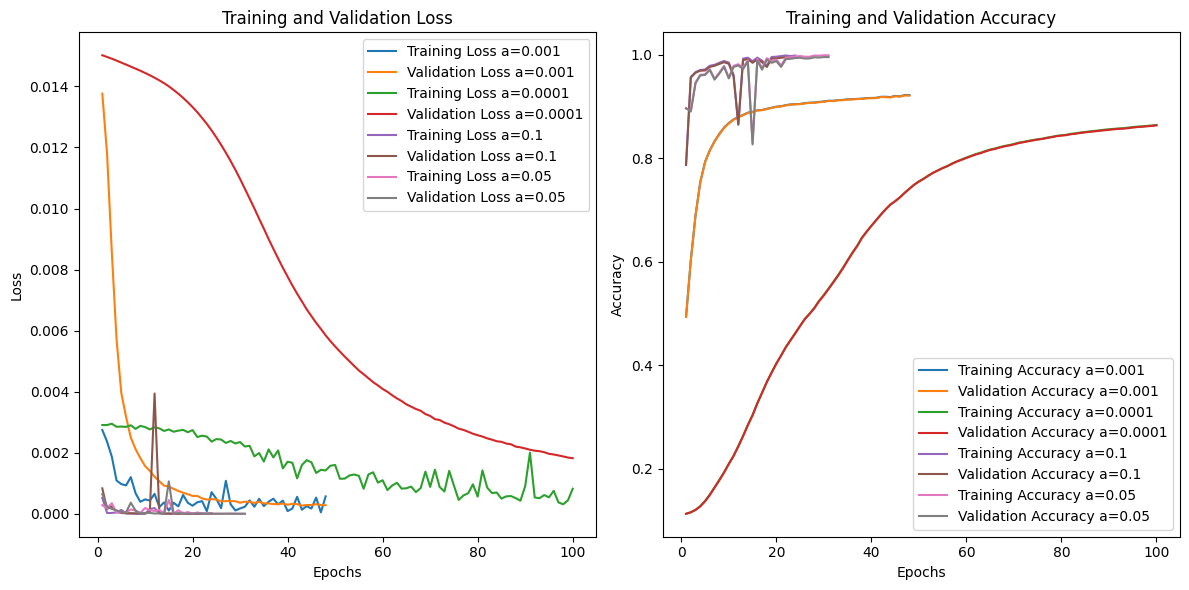

In [ ]:
print(f"best test accuracy till now: {besttest_accuracy:.4f}")

# Dynamically set epochs based on the lengths of the loss/accuracy lists
lengths = [
    len(train_loss1),
    len(train_loss2),
    len(train_loss3),
    len(train_loss4)
]

# Generate epochs for each case based on the specific list length
epochs1 = range(1, len(train_loss1) + 1)
epochs2 = range(1, len(train_loss2) + 1)
epochs3 = range(1, len(train_loss3) + 1)
epochs4 = range(1, len(train_loss4) + 1)

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_loss1, label="Training Loss a=0.001")
plt.plot(epochs1, val_loss1, label="Validation Loss a=0.001")
plt.plot(epochs2, train_loss2, label="Training Loss a=0.0001")
plt.plot(epochs2, val_loss2, label="Validation Loss a=0.0001")
plt.plot(epochs3, train_loss3, label="Training Loss a=0.1")
plt.plot(epochs3, val_loss3, label="Validation Loss a=0.1")
plt.plot(epochs4, train_loss4, label="Training Loss a=0.05")
plt.plot(epochs4, val_loss4, label="Validation Loss a=0.05")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs1, train_acc1, label="Training Accuracy a=0.001")
plt.plot(epochs1, val_acc1, label="Validation Accuracy a=0.001")
plt.plot(epochs2, train_acc2, label="Training Accuracy a=0.0001")
plt.plot(epochs2, val_acc2, label="Validation Accuracy a=0.0001")
plt.plot(epochs3, train_acc3, label="Training Accuracy a=0.1")
plt.plot(epochs3, val_acc3, label="Validation Accuracy a=0.1")
plt.plot(epochs4, train_acc4, label="Training Accuracy a=0.05")
plt.plot(epochs4, val_acc4, label="Validation Accuracy a=0.05")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
BATCH_SIZE=32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss1,val_loss1,train_acc1,val_acc1=train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy

Epoch [1/100], Train Loss: 0.0002, Val Loss: 0.0003 , train acc :0.8948 , validation acc : 0.8945
Epoch [2/100], Train Loss: 0.0002, Val Loss: 0.0002 , train acc :0.9057 , validation acc : 0.9052
Epoch [3/100], Train Loss: 0.0004, Val Loss: 0.0001 , train acc :0.9270 , validation acc : 0.9264
Epoch [4/100], Train Loss: 0.0001, Val Loss: 0.0001 , train acc :0.9389 , validation acc : 0.9384
Epoch [5/100], Train Loss: 0.0000, Val Loss: 0.0001 , train acc :0.9456 , validation acc : 0.9448
Epoch [6/100], Train Loss: 0.0001, Val Loss: 0.0001 , train acc :0.9499 , validation acc : 0.9489
Epoch [7/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9576 , validation acc : 0.9564
Epoch [8/100], Train Loss: 0.0001, Val Loss: 0.0000 , train acc :0.9625 , validation acc : 0.9611
Epoch [9/100], Train Loss: 0.0003, Val Loss: 0.0001 , train acc :0.9616 , validation acc : 0.9600
Epoch [10/100], Train Loss: 0.0001, Val Loss: 0.0000 , train acc :0.9672 , validation acc : 0.9654
Epoch [11/100], Tra

In [ ]:
BATCH_SIZE=128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss2,val_loss2,train_acc2,val_acc2=train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy

Epoch [1/100], Train Loss: 0.0021, Val Loss: 0.0083 , train acc :0.7896 , validation acc : 0.7899
Epoch [2/100], Train Loss: 0.0016, Val Loss: 0.0033 , train acc :0.8665 , validation acc : 0.8654
Epoch [3/100], Train Loss: 0.0008, Val Loss: 0.0020 , train acc :0.8845 , validation acc : 0.8839
Epoch [4/100], Train Loss: 0.0008, Val Loss: 0.0015 , train acc :0.8963 , validation acc : 0.8959
Epoch [5/100], Train Loss: 0.0009, Val Loss: 0.0010 , train acc :0.9036 , validation acc : 0.9034
Epoch [6/100], Train Loss: 0.0009, Val Loss: 0.0009 , train acc :0.9093 , validation acc : 0.9092
Epoch [7/100], Train Loss: 0.0005, Val Loss: 0.0006 , train acc :0.9113 , validation acc : 0.9108
Epoch [8/100], Train Loss: 0.0009, Val Loss: 0.0005 , train acc :0.9126 , validation acc : 0.9120
Epoch [9/100], Train Loss: 0.0007, Val Loss: 0.0006 , train acc :0.9196 , validation acc : 0.9191
Epoch [10/100], Train Loss: 0.0006, Val Loss: 0.0005 , train acc :0.9225 , validation acc : 0.9218
Epoch [11/100], Tra

In [ ]:
BATCH_SIZE=512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss3,val_loss3,train_acc3,val_acc3=train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy

Epoch [1/100], Train Loss: 0.0215, Val Loss: 0.1097 , train acc :0.3575 , validation acc : 0.3580
Epoch [2/100], Train Loss: 0.0174, Val Loss: 0.0885 , train acc :0.5767 , validation acc : 0.5774
Epoch [3/100], Train Loss: 0.0126, Val Loss: 0.0631 , train acc :0.7295 , validation acc : 0.7285
Epoch [4/100], Train Loss: 0.0085, Val Loss: 0.0463 , train acc :0.7837 , validation acc : 0.7830
Epoch [5/100], Train Loss: 0.0071, Val Loss: 0.0376 , train acc :0.8119 , validation acc : 0.8118
Epoch [6/100], Train Loss: 0.0070, Val Loss: 0.0328 , train acc :0.8333 , validation acc : 0.8327
Epoch [7/100], Train Loss: 0.0054, Val Loss: 0.0298 , train acc :0.8503 , validation acc : 0.8497
Epoch [8/100], Train Loss: 0.0044, Val Loss: 0.0279 , train acc :0.8640 , validation acc : 0.8633
Epoch [9/100], Train Loss: 0.0043, Val Loss: 0.0259 , train acc :0.8727 , validation acc : 0.8718
Epoch [10/100], Train Loss: 0.0052, Val Loss: 0.0247 , train acc :0.8791 , validation acc : 0.8787
Epoch [11/100], Tra

In [ ]:
BATCH_SIZE=2048
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss4,val_loss4,train_acc4,val_acc4=train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model
  besttest_accuracy=test_accuracy

Epoch [1/100], Train Loss: 0.0942, Val Loss: 0.5655 , train acc :0.1944 , validation acc : 0.1942
Epoch [2/100], Train Loss: 0.0925, Val Loss: 0.5548 , train acc :0.2760 , validation acc : 0.2759
Epoch [3/100], Train Loss: 0.0906, Val Loss: 0.5429 , train acc :0.3559 , validation acc : 0.3558
Epoch [4/100], Train Loss: 0.0882, Val Loss: 0.5282 , train acc :0.4215 , validation acc : 0.4213
Epoch [5/100], Train Loss: 0.0858, Val Loss: 0.5098 , train acc :0.4743 , validation acc : 0.4740
Epoch [6/100], Train Loss: 0.0819, Val Loss: 0.4870 , train acc :0.5193 , validation acc : 0.5192
Epoch [7/100], Train Loss: 0.0762, Val Loss: 0.4592 , train acc :0.5599 , validation acc : 0.5601
Epoch [8/100], Train Loss: 0.0706, Val Loss: 0.4270 , train acc :0.6131 , validation acc : 0.6133
Epoch [9/100], Train Loss: 0.0651, Val Loss: 0.3920 , train acc :0.6651 , validation acc : 0.6655
Epoch [10/100], Train Loss: 0.0603, Val Loss: 0.3570 , train acc :0.7026 , validation acc : 0.7027
Epoch [11/100], Tra

How Batch Size Affects Model Performance  
Small Batch Sizes:

Training Speed: Slower due to more weight updates.  
Model Accuracy: Can lead to better generalization but noisier convergence.  
Memory Usage: Efficient on GPUs with limited memory.  
Large Batch Sizes:  
Training Speed: Faster per epoch, but total time to convergence may increase.  
Model Accuracy: May result in poorer generalization if the batch is too large.  
Memory Usage: High memory consumption, requiring powerful GPUs.


0.9785


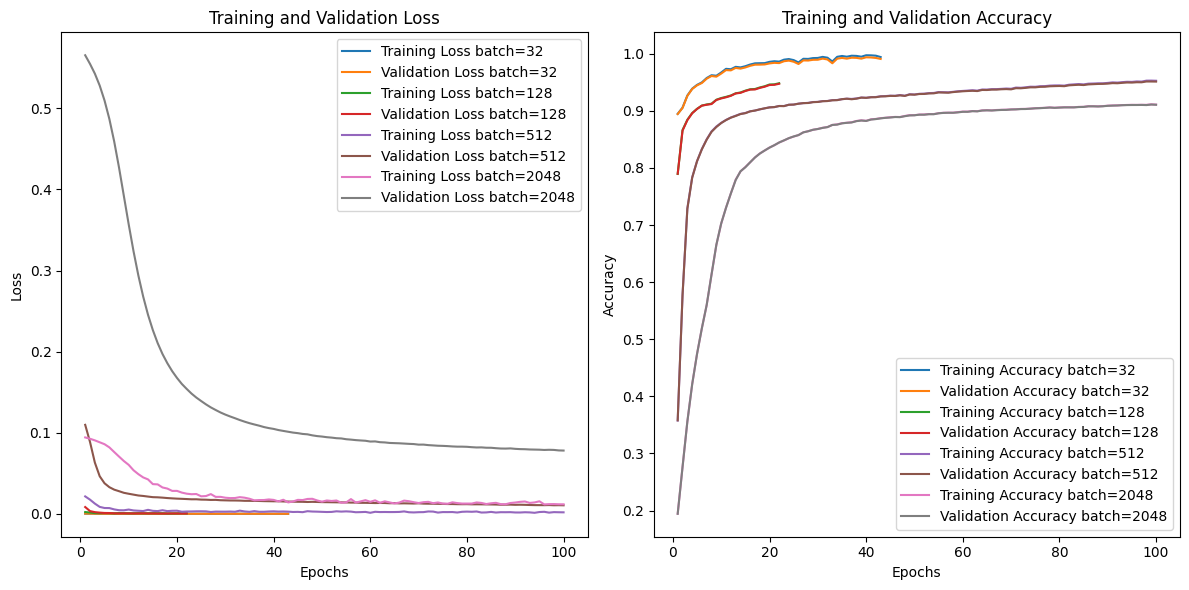

In [ ]:
print(besttest_accuracy)

# Dynamically set epochs based on the lengths of the loss/accuracy lists
lengths = [
    len(train_loss1),
    len(train_loss2),
    len(train_loss3),
    len(train_loss4)
]

# Generate epochs for each case based on the specific list length
epochs1 = range(1, len(train_loss1) + 1)
epochs2 = range(1, len(train_loss2) + 1)
epochs3 = range(1, len(train_loss3) + 1)
epochs4 = range(1, len(train_loss4) + 1)

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_loss1, label="Training Loss batch=32")
plt.plot(epochs1, val_loss1, label="Validation Loss batch=32")
plt.plot(epochs2, train_loss2, label="Training Loss batch=128")
plt.plot(epochs2, val_loss2, label="Validation Loss batch=128")
plt.plot(epochs3, train_loss3, label="Training Loss batch=512")
plt.plot(epochs3, val_loss3, label="Validation Loss batch=512")
plt.plot(epochs4, train_loss4, label="Training Loss batch=2048")
plt.plot(epochs4, val_loss4, label="Validation Loss batch=2048")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs1, train_acc1, label="Training Accuracy batch=32")
plt.plot(epochs1, val_acc1, label="Validation Accuracy batch=32")
plt.plot(epochs2, train_acc2, label="Training Accuracy batch=128")
plt.plot(epochs2, val_acc2, label="Validation Accuracy batch=128")
plt.plot(epochs3, train_acc3, label="Training Accuracy batch=512")
plt.plot(epochs3, val_acc3, label="Validation Accuracy batch=512")
plt.plot(epochs4, train_acc4, label="Training Accuracy batch=2048")
plt.plot(epochs4, val_acc4, label="Validation Accuracy batch=2048")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
BATCH_SIZE=64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Define the feedforward neural network
class FeedforwardNN2(nn.Module):  #neural network defined
    def __init__(self, input_size=784, hidden_size1=128, hidden_size2=64,hidden_size3=32, output_size=10):
        super(FeedforwardNN2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) # make the y=w^T x + b
        self.relu1 = nn.ReLU()  # make activation function 1
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()  # make activation function 2
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()  # make activation function 2
        self.fc4 = nn.Linear(hidden_size3, output_size)  # applying linearity for output
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input  make it 1-d
        x = self.fc1(x)  # Apply the first linear layer
        x = self.relu1(x)  # Apply the activation function
        x = self.fc2(x)  # Apply the second linear layer
        x = self.relu2(x)  # Apply the activation function
        x = self.fc3(x)  # Apply the output linear layer
        x = self.relu3(x)  # Apply the activation function
        x = self.fc4(x)  # Apply the output linear layer
        return x  # return the output
# Initialize the model, loss function, and optimizer
model = FeedforwardNN()  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Gradient Stochastic Descent

In [ ]:
model1 = FeedforwardNN(hidden_size1=64, hidden_size2=32)  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model1.parameters(), lr=0.01)
train_loss1,val_loss1,train_acc1,val_acc1=train_model(model1, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model1.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model1
  besttest_accuracy=test_accuracy



Epoch [1/100], Train Loss: 0.0005, Val Loss: 0.0021 , train acc :0.8363 , validation acc : 0.8352
Epoch [2/100], Train Loss: 0.0004, Val Loss: 0.0010 , train acc :0.8842 , validation acc : 0.8835
Epoch [3/100], Train Loss: 0.0001, Val Loss: 0.0004 , train acc :0.9019 , validation acc : 0.9014
Epoch [4/100], Train Loss: 0.0002, Val Loss: 0.0004 , train acc :0.9106 , validation acc : 0.9101
Epoch [5/100], Train Loss: 0.0001, Val Loss: 0.0003 , train acc :0.9168 , validation acc : 0.9163
Epoch [6/100], Train Loss: 0.0001, Val Loss: 0.0005 , train acc :0.9152 , validation acc : 0.9145
Epoch [7/100], Train Loss: 0.0002, Val Loss: 0.0003 , train acc :0.9218 , validation acc : 0.9214
Epoch [8/100], Train Loss: 0.0002, Val Loss: 0.0002 , train acc :0.9281 , validation acc : 0.9277
Epoch [9/100], Train Loss: 0.0002, Val Loss: 0.0005 , train acc :0.9310 , validation acc : 0.9306
Epoch [10/100], Train Loss: 0.0002, Val Loss: 0.0002 , train acc :0.9374 , validation acc : 0.9369
Epoch [11/100], Tra

In [ ]:
model2 = FeedforwardNN(hidden_size1=265, hidden_size2=128)  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model2.parameters(), lr=0.01)
train_loss2,val_loss2,train_acc2,val_acc2=train_model(model2, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model2.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model2
  besttest_accuracy=test_accuracy

Epoch [1/100], Train Loss: 0.0007, Val Loss: 0.0016 , train acc :0.8651 , validation acc : 0.8645
Epoch [2/100], Train Loss: 0.0008, Val Loss: 0.0009 , train acc :0.8892 , validation acc : 0.8886
Epoch [3/100], Train Loss: 0.0005, Val Loss: 0.0006 , train acc :0.9039 , validation acc : 0.9034
Epoch [4/100], Train Loss: 0.0001, Val Loss: 0.0003 , train acc :0.9182 , validation acc : 0.9181
Epoch [5/100], Train Loss: 0.0002, Val Loss: 0.0003 , train acc :0.9256 , validation acc : 0.9253
Epoch [6/100], Train Loss: 0.0001, Val Loss: 0.0003 , train acc :0.9296 , validation acc : 0.9288
Epoch [7/100], Train Loss: 0.0000, Val Loss: 0.0003 , train acc :0.9354 , validation acc : 0.9348
Epoch [8/100], Train Loss: 0.0001, Val Loss: 0.0002 , train acc :0.9389 , validation acc : 0.9385
Epoch [9/100], Train Loss: 0.0003, Val Loss: 0.0001 , train acc :0.9378 , validation acc : 0.9369
Epoch [10/100], Train Loss: 0.0004, Val Loss: 0.0002 , train acc :0.9476 , validation acc : 0.9466
Epoch [11/100], Tra

In [ ]:
model3=FeedforwardNN2()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model3.parameters(), lr=0.01)
train_loss3,val_loss3,train_acc3,val_acc3=train_model(model3, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model3.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model3(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model3
  besttest_accuracy=test_accuracy

Epoch [1/100], Train Loss: 0.0009, Val Loss: 0.0040 , train acc :0.7455 , validation acc : 0.7445
Epoch [2/100], Train Loss: 0.0007, Val Loss: 0.0017 , train acc :0.8527 , validation acc : 0.8525
Epoch [3/100], Train Loss: 0.0007, Val Loss: 0.0011 , train acc :0.8680 , validation acc : 0.8676
Epoch [4/100], Train Loss: 0.0002, Val Loss: 0.0004 , train acc :0.9071 , validation acc : 0.9067
Epoch [5/100], Train Loss: 0.0001, Val Loss: 0.0004 , train acc :0.9176 , validation acc : 0.9174
Epoch [6/100], Train Loss: 0.0001, Val Loss: 0.0005 , train acc :0.9229 , validation acc : 0.9224
Epoch [7/100], Train Loss: 0.0003, Val Loss: 0.0004 , train acc :0.9276 , validation acc : 0.9268
Epoch [8/100], Train Loss: 0.0001, Val Loss: 0.0004 , train acc :0.9408 , validation acc : 0.9401
Epoch [9/100], Train Loss: 0.0001, Val Loss: 0.0003 , train acc :0.9410 , validation acc : 0.9401
Epoch [10/100], Train Loss: 0.0001, Val Loss: 0.0003 , train acc :0.9507 , validation acc : 0.9497
Epoch [11/100], Tra

In [ ]:
model4=FeedforwardNN2(hidden_size1=64, hidden_size2=32,hidden_size3=16)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model4.parameters(), lr=0.01)
train_loss4,val_loss4,train_acc4,val_acc4=train_model(model4, train_loader, val_loader, criterion, optimizer, epochs=100)
correct = 0
total = 0
model4.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model4(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy=correct/total # till now this is the best test accuracy
print(test_accuracy)
if test_accuracy>besttest_accuracy:
  best_model=model4
  besttest_accuracy=test_accuracy

Epoch [1/100], Train Loss: 0.0009, Val Loss: 0.0045 , train acc :0.7097 , validation acc : 0.7087
Epoch [2/100], Train Loss: 0.0006, Val Loss: 0.0013 , train acc :0.8654 , validation acc : 0.8652
Epoch [3/100], Train Loss: 0.0009, Val Loss: 0.0022 , train acc :0.8317 , validation acc : 0.8319
Epoch [4/100], Train Loss: 0.0004, Val Loss: 0.0005 , train acc :0.8675 , validation acc : 0.8666
Epoch [5/100], Train Loss: 0.0005, Val Loss: 0.0007 , train acc :0.9025 , validation acc : 0.9016
Epoch [6/100], Train Loss: 0.0006, Val Loss: 0.0006 , train acc :0.9194 , validation acc : 0.9190
Epoch [7/100], Train Loss: 0.0002, Val Loss: 0.0002 , train acc :0.9247 , validation acc : 0.9242
Epoch [8/100], Train Loss: 0.0001, Val Loss: 0.0005 , train acc :0.9332 , validation acc : 0.9325
Epoch [9/100], Train Loss: 0.0002, Val Loss: 0.0005 , train acc :0.9340 , validation acc : 0.9333
Epoch [10/100], Train Loss: 0.0004, Val Loss: 0.0007 , train acc :0.9369 , validation acc : 0.9365
Epoch [11/100], Tra

0.9785


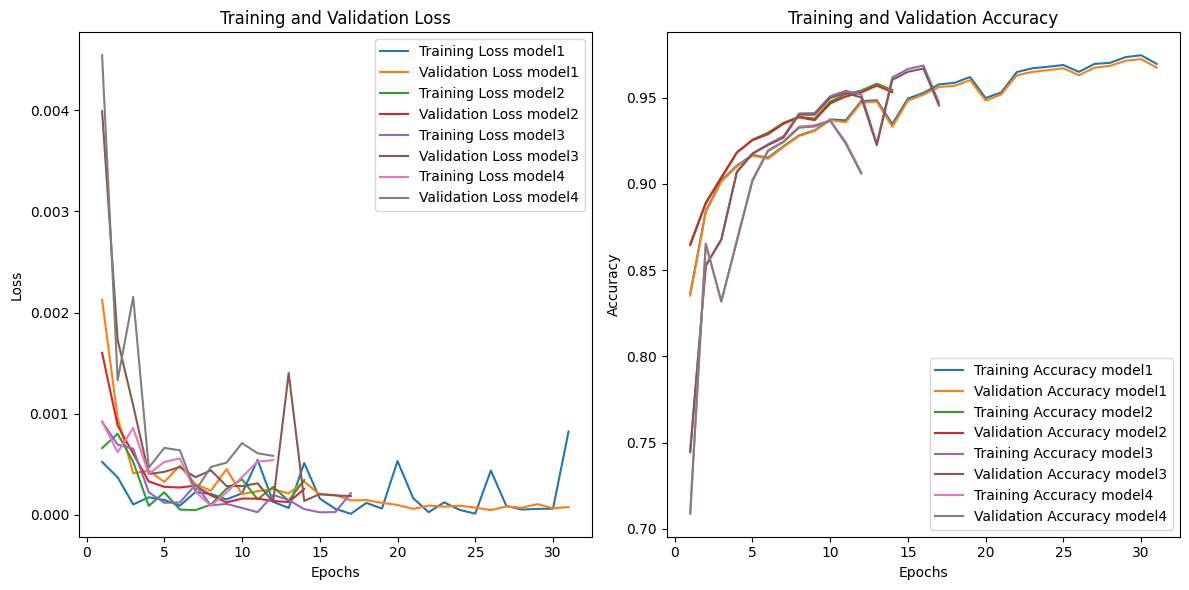

In [ ]:
print(besttest_accuracy)

# Dynamically set epochs based on the lengths of the loss/accuracy lists
epochs1 = range(1, len(train_loss1) + 1)
epochs2 = range(1, len(train_loss2) + 1)
epochs3 = range(1, len(train_loss3) + 1)
epochs4 = range(1, len(train_loss4) + 1)

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs1, train_loss1, label="Training Loss model1")
plt.plot(epochs1, val_loss1, label="Validation Loss model1")
plt.plot(epochs2, train_loss2, label="Training Loss model2")
plt.plot(epochs2, val_loss2, label="Validation Loss model2")
plt.plot(epochs3, train_loss3, label="Training Loss model3")
plt.plot(epochs3, val_loss3, label="Validation Loss model3")
plt.plot(epochs4, train_loss4, label="Training Loss model4")
plt.plot(epochs4, val_loss4, label="Validation Loss model4")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs1, train_acc1, label="Training Accuracy model1")
plt.plot(epochs1, val_acc1, label="Validation Accuracy model1")
plt.plot(epochs2, train_acc2, label="Training Accuracy model2")
plt.plot(epochs2, val_acc2, label="Validation Accuracy model2")
plt.plot(epochs3, train_acc3, label="Training Accuracy model3")
plt.plot(epochs3, val_acc3, label="Validation Accuracy model3")
plt.plot(epochs4, train_acc4, label="Training Accuracy model4")
plt.plot(epochs4, val_acc4, label="Validation Accuracy model4")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


Epoch [1/100], Train Loss: 0.0003, Val Loss: 0.0011 , train acc :0.8652 , validation acc : 0.8645
Epoch [2/100], Train Loss: 0.0004, Val Loss: 0.0004 , train acc :0.9247 , validation acc : 0.9232
Epoch [3/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9770 , validation acc : 0.9754
Epoch [4/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9814 , validation acc : 0.9798
Epoch [5/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9817 , validation acc : 0.9796
Epoch [6/100], Train Loss: 0.0001, Val Loss: 0.0000 , train acc :0.9424 , validation acc : 0.9403
Epoch [7/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9874 , validation acc : 0.9852
Epoch [8/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9907 , validation acc : 0.9881
Epoch [9/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9921 , validation acc : 0.9898
Epoch [10/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9808 , validation acc : 0.9784
Epoch [11/100], Tra

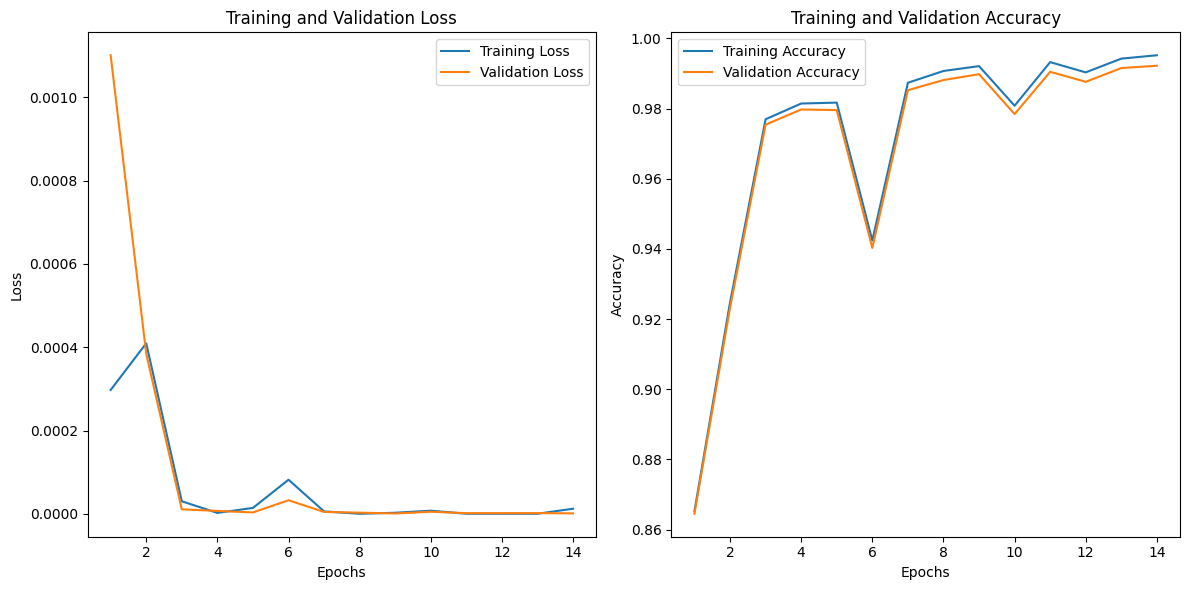

In [ ]:
#making a model with the best of best values of each
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    train_losses,val_losses,train_acc,val_acc = [], [],[],[]
    for epoch in range(epochs):  # loop for maximum 100 iterations
        model.train() # training the model
        train_loss = 0.0 #initialize loss for each epoch
        for images, labels in train_loader:  # loop on training data
            # Zero the gradients
            optimizer.zero_grad()  # start with zero gradient
            # Forward pass
            outputs = model(images)  # get the expected output of the images depending on model
            loss = criterion(outputs, labels)  # calculate the loss for the iteration
            # Backward pass
            loss.backward()  # calculate the gradient of the loss function
            optimizer.step() #make a stochastic gradient descent step
            train_loss += loss.item()
            train_loss /= len(train_loader) # Average training loss
        train_losses.append(train_loss)
        correct = 0
        total = 0
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            for images, labels in train_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                #predicted: stores the indices of the maximum values, corresponding to the predicted class labels.
                total += labels.size(0) #A counter that accumulates the number of samples processed so far during the loop.
                correct += (predicted == labels).sum().item()
        trainacc=correct/total
        train_acc.append(trainacc)
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad(): #statement in PyTorch is used to temporarily disable gradient computation
            for images, labels in val_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_loss /= len(val_loader)
            # Average validation loss
        val_losses.append(val_loss)
        validacc=correct/total
        val_acc.append(validacc)
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} , train acc :{trainacc:.4f} , validation acc : {validacc:.4f}")
        #early exit process happen
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # Reset patience counter
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Stopping early!")
            return train_losses, val_losses ,train_acc,val_acc
    return train_losses, val_losses ,train_acc,val_acc
BATCH_SIZE=32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
model2 = FeedforwardNN(hidden_size1=265, hidden_size2=128)  # make a new neural network
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model2.parameters(), lr=0.1)
train_losses,val_losses,train_accuracy,val_accuracy=train_model(model2, train_loader, val_loader, criterion, optimizer, epochs=100)
model2.eval()
test_loss = 0
correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model2(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.numpy())
        all_preds.extend(predicted.numpy())
test_loss /= len(test_loader)
test_accuracy = 100 * (correct / total)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()



Epoch [1/100], Train Loss: 0.0001, Val Loss: 0.0000 , train acc :0.9703 , validation acc : 0.9703
Epoch [2/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9828 , validation acc : 0.9822
Epoch [3/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9823 , validation acc : 0.9817
Epoch [4/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9882 , validation acc : 0.9874
Epoch [5/100], Train Loss: 0.0001, Val Loss: 0.0000 , train acc :0.9881 , validation acc : 0.9874
Epoch [6/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9914 , validation acc : 0.9904
Epoch [7/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9912 , validation acc : 0.9901
Epoch [8/100], Train Loss: 0.0003, Val Loss: 0.0000 , train acc :0.9845 , validation acc : 0.9835
Epoch [9/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9934 , validation acc : 0.9919
Epoch [10/100], Train Loss: 0.0000, Val Loss: 0.0000 , train acc :0.9944 , validation acc : 0.9928
Epoch [11/100], Tra

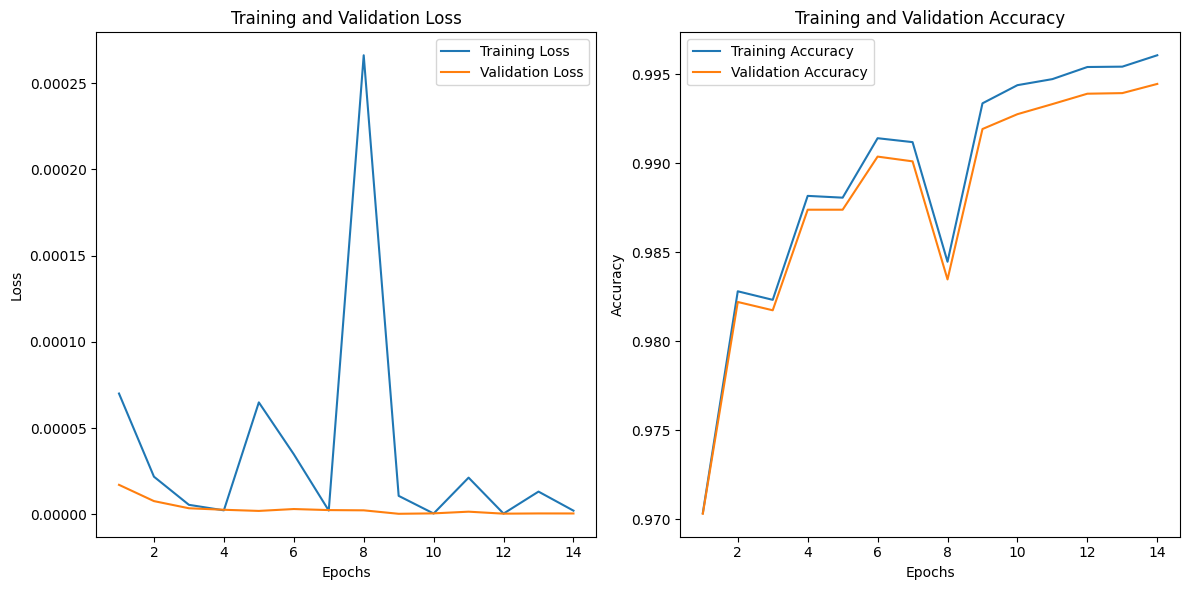

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, output_size=10):
        super(CNNModel, self).__init__()
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm([32, 28, 28])  # Layer Normalization for Conv1 output
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm2 = nn.LayerNorm([64, 14, 14])  # Layer Normalization for Conv2 output
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Max Pooling
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, output_size)
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout with 50% probability
    def forward(self, x):
        x = self.pool1(self.norm1(self.conv1(x)))  # Apply Conv1, Norm1, Pool1
        x = self.pool2(self.norm2(self.conv2(x)))  # Apply Conv2, Norm2, Pool2
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc1(x)  # First fully connected layer
        x = self.dropout(x)  # Apply Dropout during training
        x = self.fc2(x)  # Output layer
        return x
def train_model_conv(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    patience=5
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize parameters
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_acc.append(train_accuracy)
        # Validation phase (without Dropout)
        model.eval()  # Set model to evaluation mode (turn off dropout)
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():  # No gradient calculation for validation
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)  # Get predicted class
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_acc.append(val_accuracy)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Accuracy: {train_accuracy:.2f}% | Val Loss: {val_loss/len(val_loader):.4f} | "
              f"Val Accuracy: {val_accuracy:.2f}%")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # Reset patience counter
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement > patience:
            print("Stopping early!")
            return train_losses, val_losses ,train_acc,val_acc
model=CNNModel()
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_losses, val_losses,train_accuracy,val_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)
plot_fn()



1.Convolutional Layers: Use nn.Conv2d for convolutional layers, which are better suited for image data like MNIST.
2.Max Pooling Layers: Use nn.MaxPool2d to reduce the spatial dimensions of feature maps.
3.Dropout Layers: Use nn.Dropout to randomly set some of the activations to zero during training, helping with regularization and preventing overfitting.
4.Layer Normalization: Apply nn.LayerNorm to normalize the output of a layer, which can help with convergence during training.


1.Convolutional Layers (nn.Conv2d):

conv1: Takes 1 input channel (grayscale image), outputs 32 channels, and uses a 3x3 kernel with padding to preserve the spatial dimensions.
conv2: Takes 32 input channels (from the previous convolutional layer) and outputs 64 channels.

2.Max Pooling (nn.MaxPool2d):

Pooling is used to reduce the spatial dimensions after each convolutional block, which also helps reduce computational complexity and prevents overfitting.

3.Layer Normalization (nn.LayerNorm):

norm1 and norm2: Normalize the output of the convolutional layers to stabilize training and improve convergence.
4.Dropout Layer (nn.Dropout):

After the first fully connected layer (fc1), dropout is applied with a probability of 0.5 to randomly set half of the neurons to zero during training. This helps prevent overfitting by making the model more robust.

Training Performance:

With Dropout: The model should be less prone to overfitting, meaning it will generalize better to unseen data. However, dropout may slightly slow down training as some neurons are randomly dropped during each update.
With Layer Normalization: The model will likely converge faster due to stabilized training. Layer normalization helps with issues like vanishing/exploding gradients by ensuring that activations are normalized, thus improving the flow of gradients.
Final Performance:

Without Dropout: The model might achieve slightly higher accuracy on the training set, but it could overfit and perform poorly on the validation or test set.
Without Layer Normalization: The model might converge more slowly or get stuck in poor local minima. Training might also be more sensitive to the learning rate.
